# Section 3: THE UNREASONABLE EFFECTIVENESS OF VALIDATION / TEST LOSS
## Section summary
- Validation loss shows information which is not present in train loss/accuracy, and is less clear in generalisation error (validation-train)
- Underfitting = difficult to decrease validation or training loss = an undercapacity of the model to fit to the data
- Overfitting = overcapacity of model = large generalisation error = increase in validation loss
- Horizontal loss = optimum point = goal of hyper parameter (HP) tuning
- Early signs of over/under fitting can be useful for HP tuning = reduction in search time

## Example
Let's take the same model and train with two different learning rates.

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data, features = importData()

Training on 250000 datapoints with 31 features:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [3]:
preprocParams = {'normIn':True, 'pca':False}
compileArgs1 = {'loss':'binary_crossentropy', 'optimizer':'sgd', 'lr':1e1, 'depth':3, 'width':128}
compileArgs2 = {'loss':'binary_crossentropy', 'optimizer':'sgd', 'lr':5e2, 'depth':3, 'width':128}
trainParams = {'epochs':100, 'batch_size':256, 'verbose':0}
model1Params = {'version':'modelRelu', 'nIn':len(features), 'compileArgs':compileArgs1}
model2Params = {'version':'modelRelu', 'nIn':len(features), 'compileArgs':compileArgs2}

In [4]:
trainIndeces, valIndeces = train_test_split([i for i in data.index.tolist()], test_size=0.2)
train, val = foldPrep(data.iloc[trainIndeces], data.iloc[valIndeces], features, preprocParams)

In [5]:
model1, history1, _ = trainClassifier(getModel(**model1Params), train, val, trainParams, useEarlyStop=False)

In [15]:
model2, history2, _ = trainClassifier(getModel(**model2Params), train, val, trainParams, useEarlyStop=False)

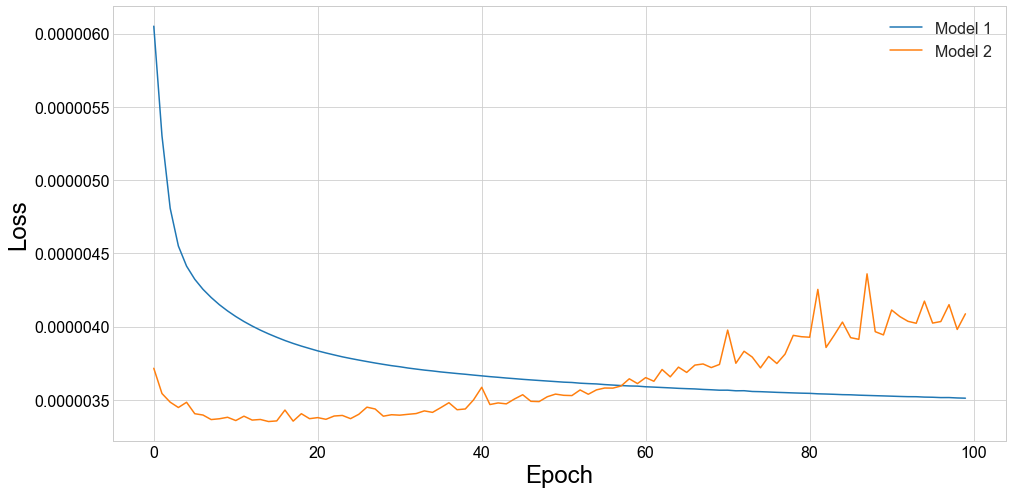

In [17]:
getModelHistoryComparisonPlot([history1, history2], ['Model 1', 'Model 2'])

Model 1 demonstrates underfitting, which can be seen from the slowly, but continuously, decreasing loss. Model 2 instead uses a higher learning rate to achieve better performance much faster, and shows a flat loss around epoch 15 (before overfitting).

Increasing the learning rate helps avoid underfitting, however both large and small LRs can lead to overfitting. Optimal learning rates can be found using a [LR range test](https://arxiv.org/abs/1506.01186), as shown below:

Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 5.4044e-06

______________________________________
Training finished
LR finder took 2.444s 


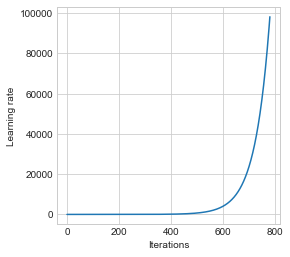

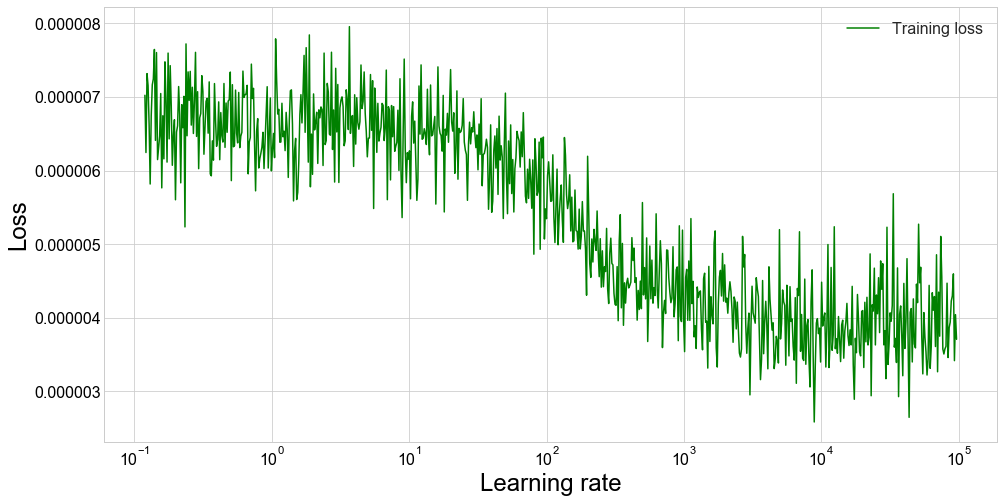

______________________________________



In [18]:
lrFinder = runLRFinder(data, features, model1Params, trainParams, preprocParams, useValidation=0, lrBounds=[1e-1, 1e5]) 

The LR begins very small, and is gradually increased. At around 10, the network begins to train (loss decreases). At 1000, the LR is so large that the network begins to diverge (loss increases). The best LR is the largest one for which the network is still able to learn, i.e. around 500.